In [98]:
import color_classify
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from IPython.display import display, HTML
from PIL import Image
from scipy.stats import pearsonr, spearmanr
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from transformers import AutoTokenizer, DistilBertForMultipleChoice


### Mock Client Models

In [2]:
# Half of the Inference Model Stored on Client Side
class ClientResNet(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super(ClientResNet, self).__init__(*args, **kwargs)
        
        # Load ResNet50 pre-trained model without top (fully connected) layers
        resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        resnet_base.trainable = False
        
        # Get the output of the first three convolutional layers
        middle_layer = resnet_base.get_layer('conv3_block4_out')
        self.seq0 = Model(inputs=resnet_base.input, outputs=middle_layer.output)
        
        resnet_base = None

        # Get cluster centers for cluster-based differential privacy
        self.color_centers = {}
        for i in range(0, 30):
            self.color_centers[i] = np.load(f"../polyvore_outfits/noise_embeddings/color_emb_{i}.npy")

        self.gmm_model = joblib.load('../polyvore_outfits/gmm_color_model.pkl')

    # Convert image into right dimensions
    def preprocess_image(self, img):
        img_array = kimage.img_to_array(img)
        expand_img = np.expand_dims(img_array, axis=0)
        return preprocess_input(expand_img)
    
    # Add laplacian noise to embedding
    def add_laplacian_noise(self, emb, noise_scale):
        laplace_noise = np.random.laplace(0.0, noise_scale, size=emb.shape)
        emb += laplace_noise
        return emb
    
    # Add laplacian noise to embedding that is sign-controlled
    def add_cluster_based_noise(self, emb, item_rgb, noise_scale):
        # Get probabilities that it belongs to a certain cluster
        cluster_idx = self.gmm_model.predict(np.array(item_rgb).reshape(1, -1))[0]

        # Add controlled-random noise
        laplacian_noise = np.random.laplace(0.0, noise_scale, size=emb.shape)

        # Calculate distances after adding/subtracting the Laplacian noise
        distance_after_add = np.abs(emb + laplacian_noise - self.color_centers[cluster_idx])
        distance_after_sub = np.abs(emb - laplacian_noise - self.color_centers[cluster_idx])

        # Compare distances to determine direction of noise addition
        add_mask = distance_after_add > distance_after_sub
        subtract_mask = ~add_mask

        # Apply noise according to the determined direction
        laplacian_noise *= add_mask.astype(float) - subtract_mask.astype(float)

        return emb + laplacian_noise
        
    # Forward pass of the client model
    def predict(self, image_path, laplace_noise=False, cluster_noise=False, noise_scale=0.35):
        # Open and process the image
        img = Image.open(image_path)
        img = img.resize((224, 224)).convert("RGB")

        preprocessed_img = self.preprocess_image(img)
        img.close()

        # Feed through ResNet
        emb = self.seq0(preprocessed_img)

        # Apply noise
        if laplace_noise:
            emb = self.add_laplacian_noise(emb, noise_scale)
        elif cluster_noise:
            item_rgb = color_classify.get_color(image_path)
            emb = self.add_cluster_based_noise(emb, item_rgb, noise_scale)

        return emb
    
    # Needed for subclass
    def call(self, inputs):
        return self.seq0(inputs)

# Instantiate Model
ClientModel = ClientResNet()

### Files to Load

In [3]:
# Data paths
data_dir = "../polyvore_outfits/"
images_path = data_dir + "images/"

# Load in embeddings
embeddings_path = data_dir + "embeddings.npy"
embeddings = np.load(embeddings_path)

# Load in filenames
filenames_path = data_dir + "filenames.txt"
filenames_file = open(filenames_path, 'r')
filenames = [line.strip() for line in filenames_file.readlines()]

# Error checking for embeddings + filenames
if len(embeddings) != len(filenames):
    print("STOP. The lengths of embeddings and filenames don't match")
    print(len(embeddings), len(filenames))

# Load in outfits metadata
outfits_metadata_path = data_dir + "outfits_metadata.json"
outfits_file = open(outfits_metadata_path, 'r')
outfit_map = json.load(outfits_file)

# Load in item (clothing) metadata
item_metadata_path = data_dir + "item_metadata.json"
items_file = open(item_metadata_path, 'r')
items_map = json.load(items_file)

# Inverted index from image to boards they are part of
item_to_outfits = {}
for outfit_id, metadata in outfit_map.items():
    for item in metadata['items']:
        item_id = item['item_id']
        item_to_outfits[item_id] = item_to_outfits.get(item_id, []) + [outfit_id]
        

### Mock Server Models

In [4]:
# Create nearest neighbor search for embeddings
neighbors = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='euclidean')
neighbors.fit(embeddings)

# Half of the Inference Model Stored on Server Side
class ServerResnet(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super(ServerResnet, self).__init__(*args, **kwargs)
        
        # Load ResNet50 pre-trained model without top (fully connected) layers
        resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        resnet_base.trainable = False
        
        # Get the output of the last two convolutional layer before Pooling
        middle_layer = resnet_base.get_layer('conv3_block4_out')
        last_conv_layer = resnet_base.get_layer('conv5_block3_out')

        self.seq1 = tf.keras.Sequential([
            Model(inputs=middle_layer.output, outputs=last_conv_layer.output),
            tf.keras.layers.GlobalMaxPooling2D(),
        ])

    # Forward pass of the server model
    def call(self, inputs):
        server_embeddings = self.seq1(inputs)

        # Normalize data
        flatten_result = tf.keras.layers.Flatten()(server_embeddings)
        result_normalized = flatten_result / tf.norm(flatten_result)
        return result_normalized[0]

ServerModel = ServerResnet()


In [79]:
def display_items(distance, indices):
    html_string, boards, matched_ids = "", [], []

    # Display similar items
    for file_idx in indices[0]:
        # Load in images
        filename = filenames[file_idx]
        img_tag = f"<img src='{images_path + filename}' style='width:{100}px;height:{100}px;margin:0;padding:0;'>"
        html_string += img_tag

        # Get boards for associated images
        img_path = filenames[file_idx][:-4]
        img_board = item_to_outfits.get(img_path, [])
        boards.extend(img_board)
        matched_ids.extend([filename[:-4] for i in range(len(img_board))])

    return boards, html_string, matched_ids

### Gather Evaluation Dataset

In [122]:
categories = {
    3 : "dress",
    7 : "skirt", 
    11 : "shirt",
    21 : "tshirt",
    23 : "jacket",
    28 : "pants",
    29: "short"s,
    37: "purse",
    43: "heels",
    47: "flats",
    49: "sneakers",
    55: "hat",
    56: "tie",
    62: "necklace", 
    64: "earrings", 
    253: "sweatpants",
    1606: "women's swimsuit",
    4456: "male jacket",
}

SyntaxError: invalid syntax (2816424681.py, line 8)

In [71]:
category_items = {key: [] for key in categories}

for key, item_json in items_map.items():
    category_id = int(item_json["category_id"])

    # Find matching category_id
    if category_id in categories.keys() and len(category_items[category_id]) < 10:
        category_items[category_id].append(key)


dress


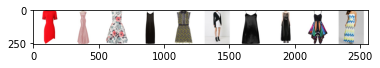

skirt


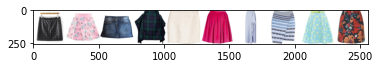

shirt


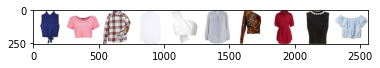

tshirt


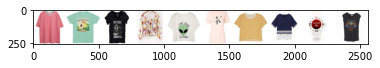

jacket


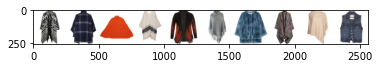

pants


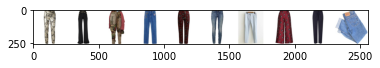

short


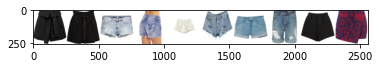

purse


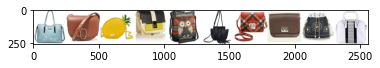

heels


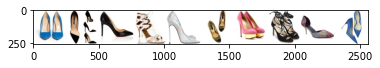

flats


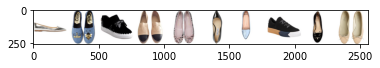

sneakers


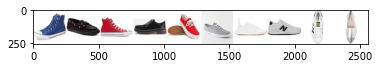

hat


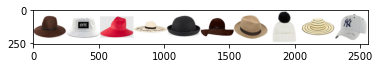

tie


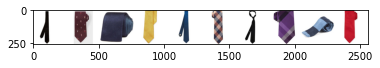

necklace


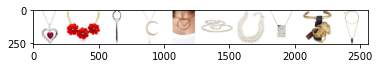

earrings


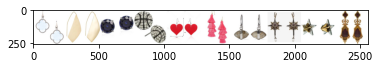

sweatpants


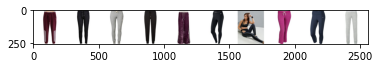

women's swimsuit


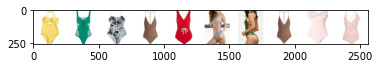

male jacket


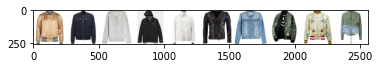

In [72]:
def create_category_board(image_paths):
    concatenated_image = np.zeros((256, 0, 3), dtype=np.uint8)

    # Loop through paths
    for image_id in image_paths:
        # Get the image
        image = Image.open(images_path + str(image_id) + ".jpg")
        image = np.array(image.resize((256, 256), Image.LANCZOS))
        image_array = np.array(image)
        concatenated_image = np.concatenate((concatenated_image, image_array), axis=1)

    return concatenated_image

for key, category_lst in category_items.items():
    print(categories[key])
    category_board = create_category_board(category_lst)
    plt.imshow(category_board)
    plt.show()


### Evaluation

In [118]:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions - targets) ** 2))

def spearman_coeff(gt_idxs, idxs2, idxs3):
    gt_names = [filenames[idx] for idx in gt_idxs]
    names2 = [filenames[idx] for idx in idxs2]
    names3 = [filenames[idx] for idx in idxs3]

    # Create a ground truth mapping
    name_to_rank = {name: i + 1 for i, name in enumerate(gt_names)}
    gt_ranks = [i for i in range(1,11)]

    # Convert names 
    ranks2 = [name_to_rank.get(name, 11) for name in names2]
    ranks3 = [name_to_rank.get(name, 11) for name in names3]

    return spearmanr(gt_ranks, ranks2)[0], spearmanr(gt_ranks, ranks3)[0]

In [161]:
laplace_errors, cluster_errors = [], []
laplace_pearsons, cluster_pearsons = [], []
laplace_spear, cluster_spear = [], []

# Get the RSMEs and Pearson Correlation Coefficients of the rows
for key, category_lst in category_items.items():
    laplace_err_row, cluster_err_row = [], []
    laplace_pearson_row, cluster_pearson_row = [], []
    laplace_spear_row, cluster_spear_row = [], []

    print("Starting", categories[key])
    # Loop through a type of item list
    for img_name in category_lst:
        # Client Predictions with and without Noise
        image_path = images_path + str(img_name) + ".jpg"
        client_embeddings = ClientModel.predict(image_path)
        noise_embeddings = ClientModel.predict(image_path, False, True)
        cluster_embeddings = ClientModel.predict(image_path, True, False)

        # Server Predictions
        server_embeddings = ServerModel.call(client_embeddings)
        server_embeddings2 = ServerModel.call(noise_embeddings)
        server_embeddings3 = ServerModel.call(cluster_embeddings)

        # RSME and Laplace Errors
        laplace_err_row.append(rmse(client_embeddings, noise_embeddings))
        cluster_err_row.append(rmse(client_embeddings, cluster_embeddings))
        laplace_pearson_row.append(pearsonr(server_embeddings, server_embeddings2)[0])
        cluster_pearson_row.append(pearsonr(server_embeddings, server_embeddings3)[0])

        # Get the nearest neighbors
        distance, indices1 = neighbors.kneighbors([server_embeddings])
        board_ids, html_string, matched_ids1 = display_items(distance, indices1)
        # display(HTML(html_string))

        distance, indices2 = neighbors.kneighbors([server_embeddings2])
        board_ids, html_string, matched_ids2 = display_items(distance, indices2)
        # display(HTML(html_string))

        distance, indices3 = neighbors.kneighbors([server_embeddings3])
        board_ids, html_string, matched_ids3 = display_items(distance, indices3)
        # display(HTML(html_string))

        # Calculate spearman coefficients
        coeff1, coeff2 = spearman_coeff(indices1[0], indices2[0], indices3[0])
        laplace_spear_row.append(coeff1)
        cluster_spear_row.append(coeff2)

    # Append the rows
    laplace_errors.append(laplace_err_row)
    cluster_errors.append(cluster_err_row)
    laplace_pearsons.append(laplace_pearson_row)
    cluster_pearsons.append(cluster_pearson_row)
    laplace_spear.append(laplace_spear_row)
    cluster_spear.append(cluster_spear_row)

laplace_errors, laplace_pearsons, laplace_spear = np.array(laplace_errors), np.array(laplace_pearsons), np.array(laplace_spear)
cluster_errors, cluster_pearsons, cluster_spear = np.array(cluster_errors), np.array(cluster_pearsons), np.array(cluster_spear)

Starting dress
Starting skirt
Starting shirt
Starting tshirt
Starting jacket
Starting pants
Starting short
Starting purse
Starting heels
Starting flats
Starting sneakers
Starting hat
Starting tie
Starting necklace
Starting earrings
Starting sweatpants
Starting women's swimsuit
Starting male jacket


In [162]:
laplace_avg_errors = np.mean(laplace_errors, axis=1)
cluster_avg_errors = np.mean(cluster_errors, axis=1)

laplace_avg_pearsons = np.mean(laplace_pearsons, axis=1)
cluster_avg_pearsons = np.mean(cluster_pearsons, axis=1)

laplace_avg_spears = np.mean(laplace_spear, axis=1)
cluster_avg_spears = np.mean(cluster_spear, axis=1)

data = {
    "laplace_errors": laplace_errors,
    "laplace_pearsons": laplace_pearsons,
    "laplace_spear": laplace_spear,
    "cluster_errors": cluster_errors,
    "cluster_pearsons": cluster_pearsons,
    "cluster_spear": cluster_spear,
}

np.savez("results.npz", **data)

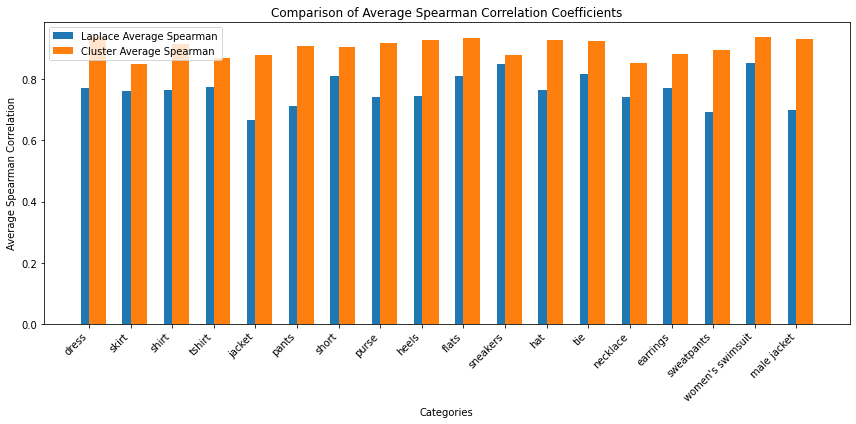

In [166]:
names = list(categories.values())

plt.figure(figsize=(12, 6))
plt.bar(names, laplace_avg_spears, width=0.4, label='Laplace Average Spearman')
plt.bar(names, cluster_avg_spears, width=0.4, label='Cluster Average Spearman', align='edge')
plt.xlabel('Categories')
plt.ylabel('Average Spearman Correlation')
plt.title('Comparison of Average Spearman Correlation Coefficients')
plt.xticks(rotation=45, ha='right')  # Rotate category labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

In [168]:
import pandas as pd

data = {
    "Variable": ["laplace_avg_errors", "cluster_avg_errors", "laplace_avg_pearsons", "cluster_avg_pearsons", "laplace_avg_spears", "cluster_avg_spears"],
    "Mean": [sum(laplace_avg_errors) / len(laplace_avg_errors), sum(cluster_avg_errors) / len(cluster_avg_errors),
             sum(laplace_avg_pearsons) / len(laplace_avg_pearsons), sum(cluster_avg_pearsons) / len(cluster_avg_pearsons),
             sum(laplace_avg_spears) / len(laplace_avg_spears), sum(cluster_avg_spears) / len(cluster_avg_spears)],
    "Variance": [sum((x - sum(laplace_avg_errors) / len(laplace_avg_errors))**2 for x in laplace_avg_errors) / len(laplace_avg_errors),
                 sum((x - sum(cluster_avg_errors) / len(cluster_avg_errors))**2 for x in cluster_avg_errors) / len(cluster_avg_errors),
                 sum((x - sum(laplace_avg_pearsons) / len(laplace_avg_pearsons))**2 for x in laplace_avg_pearsons) / len(laplace_avg_pearsons),
                 sum((x - sum(cluster_avg_pearsons) / len(cluster_avg_pearsons))**2 for x in cluster_avg_pearsons) / len(cluster_avg_pearsons),
                 sum((x - sum(laplace_avg_spears) / len(laplace_avg_spears))**2 for x in laplace_avg_spears) / len(laplace_avg_spears),
                 sum((x - sum(cluster_avg_spears) / len(cluster_avg_spears))**2 for x in cluster_avg_spears) / len(cluster_avg_spears)]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
print(df)


               Variable      Mean      Variance
0    laplace_avg_errors  0.494999  9.062359e-08
1    cluster_avg_errors  0.494956  7.052047e-08
2  laplace_avg_pearsons  0.946802  2.666969e-05
3  cluster_avg_pearsons  0.988204  6.982050e-07
4    laplace_avg_spears  0.763912  2.492243e-03
5    cluster_avg_spears  0.904826  8.018707e-04
